# Understanding and Manipulating Data in Waymax

This tutorial covers data structures in Waymax.

In [1]:
%%capture
import dataclasses
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
import os

# REPLACE THE STRING BELOW WITH THE PATH TO YOUR GOOGLE CLOUD SERVICE ACCOUNT KEY JSON FILE
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:\\Users\\20192326\\AppData\\Roaming\\gcloud\\application_default_credentials.json"

In [2]:
# Load example data.
config = dataclasses.replace(_config.WOD_1_1_0_VALIDATION, max_num_objects=32)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)

## JAX-based data structures

The key property with all data structures in Waymax is that all data is *immutable*. This is a design decision that is inherited from JAX and enables code written using Waymax to be compatible with the powerful functional transforms in JAX, such as `jit`, `vmap`, etc. While efficiency may be a concern with immutable data structures, wrapping your function in `jax.jit` will allow JAX to optimize and replace your operations with in-place operations wherever possible, avoiding the need for excessive data copying.

Additionally, all datastructures in Waymax are implemented as dataclasses. This allows convenient named access to fields, and allows simple nesting of data structures that is easy to manipulate with tree-based operations (such as those in `jax.tree_util`).

The first example we will cover is the `datatypes.Trajectory` data structure, which holds the pose information for all objects. The scenario that we loaded contains a trajectory containing the logged behavior for all agents under the `scenario.log_trajectory` attribute.

In [10]:
log_trajectory = scenario.log_trajectory

# Number of objects stored in this trajectory.
print('Number of objects:', log_trajectory.num_objects)
print('Number of timesteps:', log_trajectory.num_timesteps)
print('Trajectory shape (num_objects, num_timesteps):', log_trajectory.shape)
print('XYZ positions (num_objects, num_timesteps, 3):', log_trajectory.xyz.shape)
print('XY velocities (num_objects, num_timesteps, 2):', log_trajectory.vel_xy.shape)
print('Yaw (num_objects, num_timesteps):', log_trajectory.yaw.shape)

Number of objects: 32
Number of timesteps: 91
Trajectory shape (num_objects, num_timesteps): (32, 91)
XYZ positions (num_objects, num_timesteps, 3): (32, 91, 3)
XY velocities (num_objects, num_timesteps, 2): (32, 91, 2)
Yaw (num_objects, num_timesteps): (32, 91)


The `datatypes` module contains some helper methods that automatically map over datastructures. We can use `datatypes.dynamic_slice` to select out the trajectory belonging to a particular object or at a particular timestep. These operations, as with all JAX operations, will return new copies of the object they are modifying. 

In [11]:
# Slice by time. Select the trajectory at timestep 23.
traj_t23 = datatypes.dynamic_slice(log_trajectory, start_index=23, slice_size=1, axis=-1)
print('XYZ positions (num_objects, 1, 3):', traj_t23.xyz.shape)

# Slice by object. Select the trajectory for object 15.
traj_obj15 = datatypes.dynamic_slice(log_trajectory, start_index=15, slice_size=1, axis=-2)
print('XYZ positions (1, num_timesteps, 3):', traj_obj15.xyz.shape)

XYZ positions (num_objects, 1, 3): (32, 1, 3)
XYZ positions (1, num_timesteps, 3): (1, 91, 3)


Of course, JAX functions from the core library also work on Waymax data structures. The `tree_map` function is particularly useful for working with dataclasses, and will apply a single function to all fields in the data structure (recursively if there are nested data structures).

In [12]:
def max_along_time(x: jax.Array) -> jax.Array:
  return jnp.max(x, axis=-1, keepdims=True)

max_trajectory = jax.tree_util.tree_map(max_along_time, log_trajectory)
print('XYZ positions (num_objects, 1, 3):', max_trajectory.xyz.shape)

XYZ positions (num_objects, 1, 3): (32, 1, 3)


To modify the values of the data structure, we can use `dataclasses.replace` to replace entire fields, and `Array.at[idx].set(value)` to selectively modify individual values. For example, to set the all yaws for object 1 to zero, we can use the following code snippet:

In [6]:
zeroed_traj = dataclasses.replace(
    log_trajectory, 
    yaw=log_trajectory.yaw.at[1].set(0.0)
)

# Should be the original values.
print('Yaws for object 0, timesteps 0 to 5:', zeroed_traj.yaw[0, 0:5])

# Should be now set to 0.
print('Yaws for object 1, timesteps 0 to 5:', zeroed_traj.yaw[1, 0:5])


Yaws for object 0, timesteps 0 to 5: [-0.42366624 -0.44346142 -0.4265263  -0.4287064  -0.43463445]
Yaws for object 1, timesteps 0 to 5: [0. 0. 0. 0. 0.]


# Other important data structures

We will now cover the remaining important data structures that are stored in a scenario.

The `datatypes.RoadgraphPoints` data structure holds all static information regarding the road and environment. This includes all lanes markers, road edges, stop signs, speed bumps, and crosswalks. 
- The `x`, `y`, and `z` attributes define the spatial coordinates of the points.
- The `type` attribute is an integer that defines what type of point (lane, edge, stop sign, etc.) the point is. See `roadgraph_samples/type` of the [Waymo Open Motion Dataset](https://waymo.com/open/data/motion/tfexample) for definitions of which value corresponds to what type of point.
- The `dir_x` and `dir_y` attributes define the orientation of the points. Lane points will orient in the forward direction of the lane. Edge points are oriented such that the inside of the road is always on the port side (left if facing forward) of the point.
- The `id` field is a unique identifier for each contiguous lane. Lanes end if there is an intersection or reach the edge of the map.

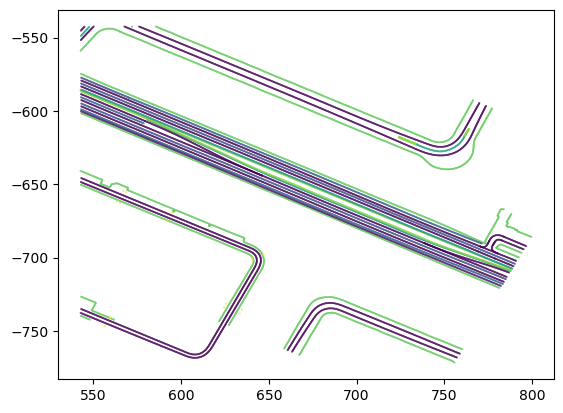

In [7]:
# Plot the roadgraph, with colors corresponding to the road type.
rg_points = scenario.roadgraph_points

where_valid = rg_points.valid
plt.scatter(
    x = rg_points.x[where_valid],
    y = rg_points.y[where_valid],
    s=0.1,
    c = rg_points.types[where_valid]
)
plt.show()

The `datatypes.TrafficLights` structure holds time-varying information regarding the color and position of the traffic lights.
- The `x`, `y`, and `z` attributes define the spatial location of the light.
- The `state` attribute defines what color the light is at a particular instance in time.
- The `lane_ids` attribute tells what lanes the traffic light is controlling. These can be cross-referenced with the `RoadgraphPoints.ids` field.

In [8]:
traffic_lights = scenario.log_traffic_light

print('Traffic Light States (num_lights, num_timesteps):', traffic_lights.shape)

Traffic Light States (num_lights, num_timesteps): (16, 91)


Finally, `datatypes.ObjectMetadata` holds 
- The `object_types` attribute defines whether the object is a vehicle, pedestrian, or cyclist.
- The `ids` attribute assigns a unique ID to each object.
- The `is_sdc` attribute defines whether the object is the ego-vehicle (or self-driving car).
- The `is_modeled` attribute marks whether the object's behavior is meant to be predicted as part of the Waymo Open Motion dataset.



All object IDS: [ 70  73  92 124  71  79  68  76  69  72  75  80  77  74  90  83  82  81
  78  91  85  87  93 119  97  98  99 101 120 102  -1  -1]


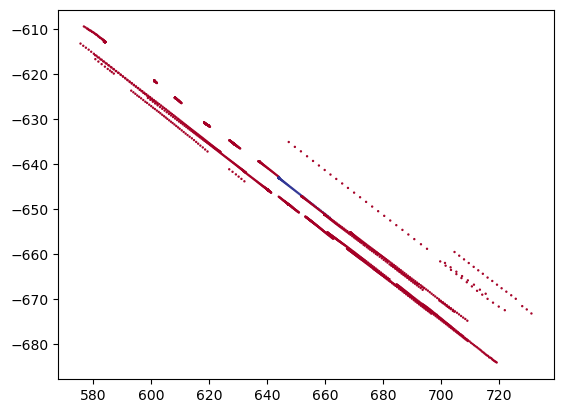

In [9]:
metadata = scenario.object_metadata
print('All object IDS:', metadata.ids)

# Color-code object trajectory by whether it is the SDC or not.
# The SDC trajectory in the center is shown in blue, and all other trajectories
# are shown in red.
flat_trajectory = jax.tree_util.tree_map(lambda x: jnp.reshape(x, [-1]), log_trajectory)
colors = jnp.zeros(log_trajectory.shape, dtype=jnp.int32).at[metadata.is_sdc].set(1)
colors = jnp.reshape(colors, [-1])

where_valid = flat_trajectory.valid
plt.scatter(
  x=flat_trajectory.x[where_valid],
  y=flat_trajectory.y[where_valid],
  s=0.5,
  c=colors[where_valid],
  cmap='RdYlBu'
)
plt.show()